In [53]:
import tensorflow as tf
from tensorflow.keras import layers, models
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report,accuracy_score, precision_score, recall_score, f1_score
from collections import Counter
import os
import random
import cv2

In [54]:
train_dir = r'/Users/minhquan/Desktop/ChestCT_Classification-main/train'
train_dataset = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    image_size = (150, 150),
    batch_size = 32,
    label_mode = 'categorical'
)

val_dir = r'/Users/minhquan/Desktop/ChestCT_Classification-main/valid'
validation_dataset = tf.keras.utils.image_dataset_from_directory(
    val_dir,
    image_size = (150,150),
    batch_size = 32,
    label_mode = 'categorical'
)

test_dir = r'/Users/minhquan/Desktop/ChestCT_Classification-main/test'
test_dataset = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    image_size = (150,150),
    batch_size = 32,
    label_mode = 'categorical'
)


Found 613 files belonging to 4 classes.
Found 72 files belonging to 4 classes.
Found 315 files belonging to 4 classes.


In [55]:
class_counts = Counter()
for images, labels in train_dataset:
    # Convert one-hot encoded labels to class indices
    class_indices = np.argmax(labels.numpy(), axis=1)
    class_counts.update(class_indices)

# Print the counts for each class
print("Number of images per class:")
for class_idx, count in class_counts.items():
    print(f"Class {class_idx}: {count} images")

Number of images per class:
Class 0: 195 images
Class 3: 155 images
Class 1: 115 images
Class 2: 148 images


2024-10-03 21:45:12.155056: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [56]:

def flip_left_right(image, label):
    image = tf.image.flip_left_right(image)
# Define a function to flip an image left-right
def flip_left_right(image, label):
    image = tf.image.flip_left_right(image)
    return image, label

# Apply the flip_left_right function to each image in the dataset
flipped_dataset = train_dataset.map(flip_left_right) 

# Concatenate with train dataset
train_dataset = train_dataset.concatenate(flipped_dataset)

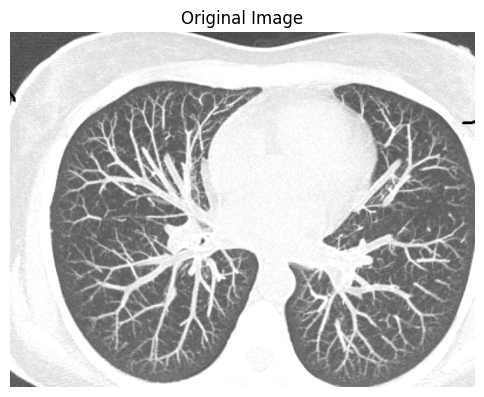

In [57]:
''' Check random image in the new train data'''

# Randomly select an image from the training set
class_name = random.choice(os.listdir(train_dir))
class_path = os.path.join(train_dir, class_name)
image_name = random.choice(os.listdir(class_path))
image_path = os.path.join(class_path, image_name)

# Load the image in grayscale
image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
# Plot the original image
plt.figure(figsize=(6, 6))

# Display the original image
plt.imshow(image, cmap='gray')
plt.title('Original Image')
plt.axis('off')  # Hide axis for cleaner display

# Show the plot
plt.show()

In [58]:
# Initialize a counter
image_count = 0

# Iterate over the dataset and count images
for images, labels in train_dataset:
    image_count += images.shape[0]  # Add the batch size (number of images in this batch)

print(f"Total number of images in the training dataset: {image_count}")


Total number of images in the training dataset: 1226


2024-10-03 21:45:13.842181: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [59]:
''' preprocess '''

'''Normalization'''
# Create normalization layer that rescale pixel values from [0,255] to [0,1]
normalization_layer = layers.Rescaling(1./255)


# Apply the normalization layer to the dataset
train_dataset = train_dataset.map(lambda x, y: (normalization_layer(x), y))
validation_dataset = validation_dataset.map(lambda x, y: (normalization_layer(x), y))
test_dataset = test_dataset.map(lambda x, y: (normalization_layer(x), y))

'''Augumentation (just do it slightly, as the medical ct is sensitive, hence, the augmentations should preserve the medical features and the structural integrity of the images)'''


# Data augmentation (minimal augmentation)
data_augmentation = tf.keras.Sequential(
    [
        # Randomly adjust the contrast of the image. 
        layers.RandomContrast(factor=(0.9, 1.1)),
        # Randomly translate (shift) the image along the height and width.
        layers.RandomTranslation(height_factor=0.1, width_factor=0.05),
        #Rotate the image by 5%
        layers.RandomRotation(0.05)
    ]
)

# Apply the augmentation to the training dataset and validation dataset
train_dataset = train_dataset.map(lambda x, y: (data_augmentation(x, training=True), y))
validation_dataset_dataset = validation_dataset.map(lambda x, y: (data_augmentation(x, training=True), y))

In [60]:
''' Build CNN model'''
# Define the CNN model architecture
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    layers.MaxPooling2D((2, 2)),
    
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(4, activation='softmax')  # Change 3 to the number of your classes
])

# Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',  # Use 'binary_crossentropy' for 2 classes
              metrics=['accuracy'])

# Summary of the model
model.summary()

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_9 (Conv2D)               │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 36992)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │     4,735,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,828,868 (18.42 MB)

 Trainable params: 4,828,868 (18.42 MB)

 Non-trainable params: 0 (0.00 B)

In [61]:
# Train the model
history = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs = 10   # Adjust the number of epochs based on your data
)


Epoch 1/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 32s 753ms/step - accuracy: 0.2899 - loss: 1.4444 - val_accuracy: 0.3611 - val_loss: 1.3156
Epoch 2/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 27s 644ms/step - accuracy: 0.4305 - loss: 1.2613 - val_accuracy: 0.4861 - val_loss: 1.1792
Epoch 3/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 29s 695ms/step - accuracy: 0.4977 - loss: 1.1044 - val_accuracy: 0.4722 - val_loss: 1.0568
Epoch 4/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 27s 669ms/step - accuracy: 0.5445 - loss: 1.0148 - val_accuracy: 0.4861 - val_loss: 1.0418
Epoch 5/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 23s 565ms/step - accuracy: 0.5547 - loss: 0.9693 - val_accuracy: 0.4861 - val_loss: 1.1247
Epoch 6/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 24s 588ms/step - accuracy: 0.5899 - loss: 0.9015 - val_accuracy: 0.4722 - val_loss: 1.0497
Epoch 7/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 25s 622ms/step - accuracy: 0.6155 - loss: 0.8744 - val_accuracy: 0.5694 - val_loss: 0.9786
Epoch 8/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 28s 668ms/step - accuracy: 0.6213 - loss: 0.8412 - val_accu

In [62]:
''' Evaluate the model'''
# Evaluate the model on the validation dataset
val_loss, val_accuracy = model.evaluate(validation_dataset)
print(f"Validation Accuracy: {val_accuracy}")

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step - accuracy: 0.5816 - loss: 0.9266
Validation Accuracy: 0.5694444179534912


In [81]:
''' Run this block to get the prediction by the model, each will give different prediction each time'''
# Get predictions on the validation set
predictions = model.predict(validation_dataset)
predicted_classes = np.argmax(predictions, axis=1)

# Get true labels from the validation dataset
true_labels = np.concatenate([y for x, y in validation_dataset], axis=0)
true_classes = np.argmax(true_labels, axis=1)

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


2024-10-03 21:57:16.660196: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


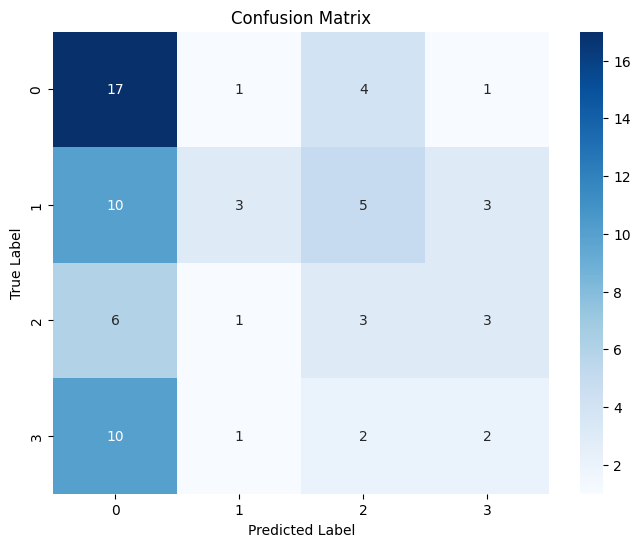

In [82]:
# Generate the confusion matrix
conf_matrix = confusion_matrix(true_classes, predicted_classes)


# Plot confusion matrix using Seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

In [83]:
# Compute accuracy
accuracy = accuracy_score(true_classes, predicted_classes)
print(f"Accuracy: {accuracy:.4f}")

# Compute precision (macro-averaged across all classes)
precision = precision_score(true_classes, predicted_classes, average='macro')
print(f"Precision (macro): {precision:.4f}")

# Compute recall (macro-averaged across all classes)
recall = recall_score(true_classes, predicted_classes, average='macro')
print(f"Recall (macro): {recall:.4f}")

# Compute F1-score (macro-averaged across all classes)
f1 = f1_score(true_classes, predicted_classes, average='macro')
print(f"F1-Score (macro): {f1:.4f}")

Accuracy: 0.3472
Precision (macro): 0.3330
Recall (macro): 0.3115
F1-Score (macro): 0.2816
